# Training Garch Model for Becnhmark

This notebook will cover all the training process for the Garch model, from the preprocess steps all the way to the to the training optimization steps. This part is intended to create a model to give a benchmark to the models we will train and experiment on, in the future.

## Data Preprocess

We will preprocess the data to train the model in the following fasion, at first we will divide the prices in a window and compute the log returns, then we will prepare each window so the model won't have look ahead bias.

## The process includes:

1. Windowed training on past log returns
2. One-step-ahead volatility forecasting
3. Recomputing features inside each window to avoid look-ahead bias
4. Evaluation metrics (RMSE, MAE, QLIKE)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
df = pd.read_csv("../data/processed/spy_garch.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [6]:
# Training Parameters
train_window = 500
test_steps = 1000

In [7]:
# Forecasting logs
predictions = []
true_volatility = []
dates = []

In [10]:
for start in range(len(df) - train_window - test_steps, len(df) - train_window):
    
    train_returns = df['Log_Returns'].iloc[start : start + train_window]
    test_return = df['Log_Returns'].iloc[start + train_window]
    test_date = df.index[start + train_window]

    try:
        model = arch_model(train_returns * 100, vol='Garch', p=1, q=1)
        res = model.fit(disp='off')
        forecast = res.forecast(horizon=1)
        predicted_variance = forecast.variance.values[-1, 0] / (100 ** 2)
        predicted_vol = np.sqrt(predicted_variance)

        predictions.append(predicted_vol)
        true_volatility.append(np.abs(test_return))  # or use rolling std target if available
        dates.append(test_date)

    except Exception as e:
        print(f"Step {start} failed: {e}")

In [11]:
preds = np.array(predictions)
true = np.array(true_volatility)

rmse = np.sqrt(mean_squared_error(true, preds))
mae = mean_absolute_error(true, preds)
qlike = np.mean(np.log(preds ** 2) + (true ** 2) / (preds ** 2))

In [12]:
print(f"\nGARCH Rolling Evaluation:")
print(f"RMSE: {rmse:.6f}")
print(f"MAE : {mae:.6f}")
print(f"QLIKE: {qlike:.6f}")


GARCH Rolling Evaluation:
RMSE: 0.008106
MAE : 0.006057
QLIKE: -8.175760


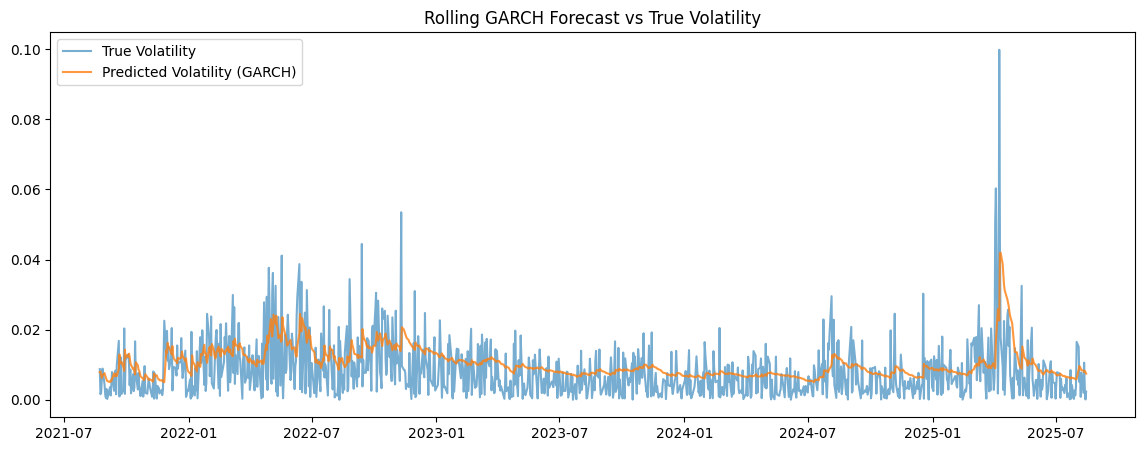

In [13]:
plt.figure(figsize=(14, 5))
plt.plot(dates, true, label='True Volatility', alpha=0.6)
plt.plot(dates, preds, label='Predicted Volatility (GARCH)', alpha=0.8)
plt.legend()
plt.title('Rolling GARCH Forecast vs True Volatility')
plt.show()

In [15]:
df_results = pd.DataFrame({
    'date': dates,
    'true_vol': true,
    'predicted_vol': preds
})
df_results.to_csv('../outputs/predictions/garch_rolling_forecast.csv', index=False)

# Model conclusions

Based on the model predictions and metrics we can see a great start, but definitely not the greatest start, even though the metrics on this model are very solid for being a preliminary model and set as a benchmark for more complex models like the TFT and LSTM models we will train ahaed in the research process.

### 🧠 Key Takeaways:
- The model achieved:
  - RMSE ≈ 0.0081 (on daily returns scale)
  - MAE  ≈ 0.0061
  - QLIKE ≈ -8.18, which reflects a well-calibrated volatility model

- GARCH remains a powerful and interpretable benchmark in volatility modeling.
- The results provide a solid foundation for comparing more complex models like LSTM and TFT.
- The rolling evaluation method ensures our model respects realistic deployment constraints.

***Next, we will implement similar workflows using LSTM and Temporal Fusion Transformer to assess if deep learning models can outperform this baseline.***